Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



# AlexNet CIFAR-10 Classifier

AlexNet [1][2] trained on CIFAR-10 [3].  
AlexNet [1][2] 在CIFAR-10 [3] 上训练。

This implementation uses grouped convolutions like in the original AlexNet paper [2]:  
该实现使用了像原始AlexNet论文[2]中那样的分组卷积：

![](../images/alexnet/alexnet-paper.png) 

Here, the network is essentially split into two parts to train it on two GPUs with 1.5 Gb RAM each.  
在这里，网络实际上被分为两部分，在两个具有1.5 GB RAM的GPU上训练。

This was purely done for computational performance reasons (and the video RAM limitation back then).  
这纯粹是出于计算性能的考虑（以及当时视频RAM的限制）。

However, there are certain benefits to using grouped convolutions ...  
然而，使用分组卷积有一些好处……

**Taking a step back, how do grouped convolutions work?**  
**回顾一下，分组卷积是如何工作的？**

In a nutshell, you can think of grouped convolutions as convolutional layers that process part of the input independently and merge the results.  
简而言之，您可以将分组卷积视为卷积层，它独立处理输入的一部分并合并结果。

So, for example, if you consider grouped convolutions with two filter groups, each filter group would process half of the channels.  
例如，如果考虑具有两个滤波器组的分组卷积，则每个滤波器组将处理一半的通道。

![](../images/alexnet/grouped-convolutions.png)  

**One of the benefits of grouped convolutions is**, as noted by Yani Ioannou [4], that AlexNet has a slightly improved accuracy when using two filter groups:  
**分组卷积的一个好处是**，正如Yani Ioannou [4] 所指出的，当使用两个滤波器组时，AlexNet的准确性略有提高：

![](../images/alexnet/alexnet-groups.png)  

**Another benefit is the reduced parameter size**.  
**另一个好处是减少了参数的大小**。

Say we have kernels with height 3 and width 3.  
假设我们有高度为3，宽度为3的卷积核。

The inputs have 6 channels, and the output channels are set to 12.  
输入有6个通道，输出通道设置为12。

Then, we have kernels with 3x3x6 weight parameters with a regular convolution.  
然后，我们有一个常规卷积的3x3x6的卷积核权重参数。

Since we have 12 output channels, that's 3x3x6x12=648 parameters in total.  
由于我们有12个输出通道，总共有3x3x6x12=648个参数。

Now, let's assume we use a grouped convolution with group size 2.  
现在，假设我们使用一个组大小为2的分组卷积。

We still have a 3x3 kernel height and width.  
我们仍然有一个3x3的卷积核的高度和宽度。

But now, the number of input channels is split by a factor of 2, so each kernel is 3x3x3.  
但现在，输入通道的数量按2的因子分割，因此每个卷积核为3x3x3。

The first group produces the first 6 output channels, so we have 3x3x3x6 parameters for the first group.  
第一个组生成前6个输出通道，因此第一个组有3x3x3x6个参数。

The second group has the same size, so we have (3x3x3x6)x2 = 3x3x3x12 = 324, which is a 2x reduction in parameters compared to the regular convolution.  
第二个组具有相同的大小，因此我们有(3x3x3x6)x2 = 3x3x3x12 = 324，与常规卷积相比，参数减少了2倍。

**And how do we do this in PyTorch?**  
**那么我们如何在PyTorch中实现呢？**

Implementing grouped convolutions in PyTorch is now really straightforward.  
在PyTorch中实现分组卷积现在非常简单。

We just used the `groups` parameter.  
我们只需要使用`groups`参数。

For example, to implement a grouped convolution with two filter groups we use  
例如，为了实现具有两个滤波器组的分组卷积，我们使用

    torch.nn.Conv2d(..., groups=2)  
    torch.nn.Conv2d(..., groups=2)  

Note that a requirement for this is that the number of input and output channels is divisible by groups (here: 2).  
请注意，这需要输入和输出通道的数量能够被组数（这里是2）整除。 

### References  
### 参考文献

- [1] L13.7 CNN Architectures & AlexNet (20:17), https://www.youtube.com/watch?v=-IHxe4-09e4  
- [1] L13.7 CNN架构与AlexNet (20:17)，https://www.youtube.com/watch?v=-IHxe4-09e4

- [2] Imagenet classification with deep convolutional neural networks, https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf  
- [2] 使用深度卷积神经网络进行Imagenet分类，https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

- [3] https://en.wikipedia.org/wiki/CIFAR-10  

- [4] https://blog.yani.ai/filter-group-tutorial/  

## Imports

In [2]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

#### Setting a random seed

I recommend using a function like the following one prior to using dataset loaders and initializing a model if you want to ensure the data is shuffled in the same manner if you rerun this notebook and the model gets the same initial random weights:  
如果你想确保数据在重新运行该笔记本并且模型得到相同的初始随机权重时以相同的方式被打乱，我建议在使用数据集加载器和初始化模型之前使用如下函数：


In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)  # 设置全局种子，用于确保训练过程的可重复性
    random.seed(seed)  # 设置Python的随机种子
    np.random.seed(seed)  # 设置NumPy的随机种子
    torch.manual_seed(seed)  # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed_all(seed)  # 设置PyTorch的所有GPU设备的随机种子

#### Setting cuDNN and PyTorch algorithmic behavior to deterministic

Similar to the `set_all_seeds` function above, I recommend setting the behavior of PyTorch and cuDNN to deterministic (this is particularly relevant when using GPUs).  
类似于上面的 `set_all_seeds` 函数，我建议将PyTorch和cuDNN的行为设置为确定性（这在使用GPU时特别重要）。

We can also define a function for that:  
我们也可以为此定义一个函数：

In [4]:
def set_deterministic():
    if torch.cuda.is_available():  # 如果CUDA可用（有GPU）
        torch.backends.cudnn.benchmark = False  # 禁用CUDNN的自动优化，以确保确定性
        torch.backends.cudnn.deterministic = True  # 强制CUDNN在GPU上执行确定性的操作
    torch.set_deterministic(True)  # 在CPU上设置PyTorch为确定性行为

In [5]:
##########################
### 设置
##########################

# 超参数
RANDOM_SEED = 1  # 随机种子
LEARNING_RATE = 0.0001  # 学习率
BATCH_SIZE = 256  # 批次大小
NUM_EPOCHS = 40  # 训练轮数

# 网络结构
NUM_CLASSES = 10  # 类别数

# 其他
DEVICE = "cuda:0"  # 使用的设备（GPU）

# 设置所有随机种子以确保可重复性
set_all_seeds(RANDOM_SEED)

# AdaptiveAvgPool2d 当前不支持确定性行为
#set_deterministic()  # 此函数确保在训练过程中具有确定性，但可能会与某些操作（如AdaptiveAvgPool2d）不兼容


#### Import utility functions

In [6]:
import sys

sys.path.insert(0, "..") # 包含 ../helper_evaluate.py 等文件

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1
### 设置随机种子 ###
set_all_seeds(RANDOM_SEED)

## Dataset

In [7]:
##########################
### 数据集
##########################

# 定义训练数据的预处理操作
train_transforms = transforms.Compose([transforms.Resize((70, 70)),  # 调整图片大小为70x70
                                       transforms.RandomCrop((64, 64)),  # 随机裁剪为64x64
                                       transforms.ToTensor()])  # 转换为Tensor格式

# 定义测试数据的预处理操作
test_transforms = transforms.Compose([transforms.Resize((70, 70)),  # 调整图片大小为70x70
                                      transforms.CenterCrop((64, 64)),  # 中心裁剪为64x64
                                      transforms.ToTensor()])  # 转换为Tensor格式


# 获取 CIFAR-10 数据集的加载器
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

In [8]:
# 检查验证数据集
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# 检查验证数据集
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# 检查验证数据集
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [9]:
##########################
### 模型
##########################

# 定义AlexNet模型
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 第一层卷积层，输入3通道，输出64通道，卷积核大小11，步长4，填充2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 最大池化层，池化大小为3，步长为2
            
            # 第二层卷积层，输入64通道，输出192通道，卷积核大小5，填充2，分组为2
            nn.Conv2d(64, 192, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 最大池化层
            
            # 第三层卷积层，输入192通道，输出384通道，卷积核大小3，填充1，分组为2
            nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            # 第四层卷积层，输入384通道，输出256通道，卷积核大小3，填充1，分组为2
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            # 第五层卷积层，输入256通道，输出256通道，卷积核大小3，填充1，分组为2
            nn.Conv2d(256, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 最大池化层
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # 自适应平均池化层，输出大小为6x6
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout层，防止过拟合
            nn.Linear(256 * 6 * 6, 4096),  # 全连接层，输入维度为256x6x6，输出维度为4096
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout层
            nn.Linear(4096, 4096),  # 全连接层，输入输出维度为4096
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)  # 最后一层，全连接层，输出类别数
        )

    def forward(self, x):
        x = self.features(x)  # 通过卷积层提取特征
        x = self.avgpool(x)  # 进行自适应平均池化
        x = x.view(x.size(0), 256 * 6 * 6)  # 将特征图展平
        logits = self.classifier(x)  # 通过全连接层
        probas = F.softmax(logits, dim=1)  # 计算每个类别的概率
        return logits  # 返回logits


In [10]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=50)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3019
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0357
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.8851
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.9109
***Epoch: 001/040 | Train. Acc.: 31.453% | Loss: 1.760
***Epoch: 001/040 | Valid. Acc.: 32.160% | Loss: 1.725
Time elapsed: 0.22 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.7038
Epoch: 002/040 | Batch 0050/0175 | Loss: 1.7065
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.6284
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.5101
***Epoch: 002/040 | Train. Acc.: 42.029% | Loss: 1.541
***Epoch: 002/040 | Valid. Acc.: 42.860% | Loss: 1.520
Time elapsed: 0.45 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.4720
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.5944
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.4508
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.3085
***Epoch: 003/040 | Train. Acc.: 48.522% | Loss: 1.382
***Epoch: 003/040 | Valid. Acc.: 49.120% | Loss: 1.373
Time elapsed: 0.68 min
Epoch: 004/040 | Batch 00

## Evaluation

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


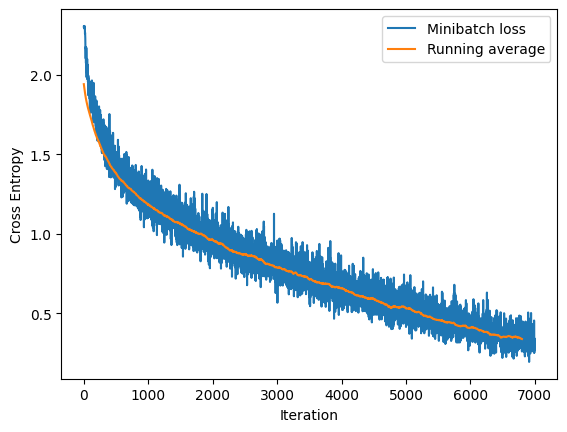

In [13]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

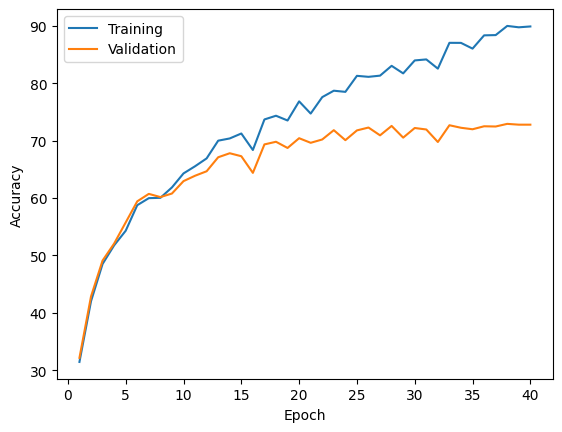

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 72.80%
Validation ACC: 72.80%
Test ACC: 70.83%


In [16]:
%watermark -iv

torch      : 2.6.0+cu126
matplotlib : 3.10.1
numpy      : 1.26.4
torchvision: 0.21.0+cu126
sys        : 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]
pandas     : 2.2.3
PIL        : 11.1.0

